# Multivariate Forecasting on Amazon Stock Price Dataset

In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from ts.data.dataset import AmazonStockPrice
from ts.utility import Utility, Metric
from ts.plot import Plot

%matplotlib inline

In [2]:
stock_df = AmazonStockPrice.loadData('/Users/ahmed/Downloads/Datasets/amazonStockPrice')
stock_df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200
...,...,...,...,...,...,...,...
5837,2020-07-27,3062.000000,3098.000000,3015.770020,3055.209961,3055.209961,4170500
5838,2020-07-28,3054.270020,3077.090088,2995.760010,3000.330078,3000.330078,3126700
5839,2020-07-29,3030.989990,3039.159912,2996.770020,3033.530029,3033.530029,2974100
5840,2020-07-30,3014.000000,3092.000000,3005.000000,3051.879883,3051.879883,6128300


In [3]:
column_names = list(stock_df.columns)

for column_name in column_names:
    print(column_name, stock_df[column_name].dtype)

Date datetime64[ns]
Open float64
High float64
Low float64
Close float64
Adj Close float64
Volume int64


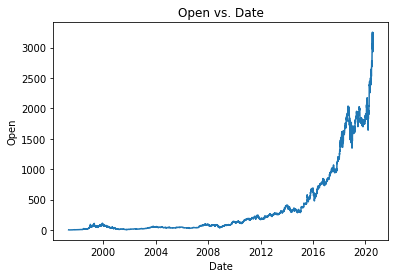

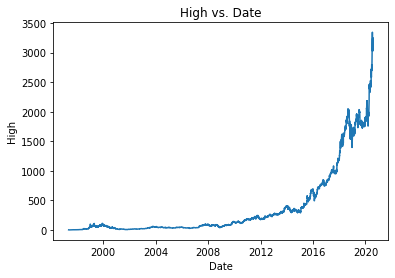

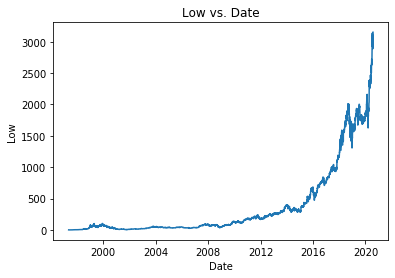

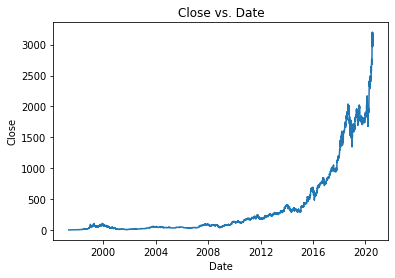

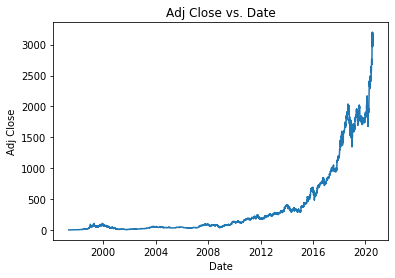

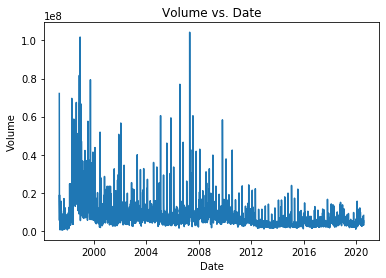

In [4]:
# Plotting the columns with respect to time

for column_name in column_names:
    if column_name == 'Date':
        continue
        
    plt.plot(stock_df['Date'].to_numpy(), stock_df[column_name].to_numpy())
    plt.xlabel('Date')
    plt.ylabel(column_name)
    plt.title(f'{column_name} vs. Date')
    plt.show()

In [5]:
# We notice that 'Adj Close' and 'Close' look quite similar
# hence, we check if they are equal

print(stock_df['Adj Close'].equals(stock_df['Close']))

True


In [6]:
# We remove Date, Volume and Adj Close
# - 'Date' columnn is not required for prediction
# - 'Volume' column doesn't seem to follow a pattern
# - 'Adj Close' column is exactly equal to 'Close'

stock_df = stock_df.drop(columns=['Date', 'Volume', 'Adj Close'])

In [7]:
# Converting to numpy array
data = stock_df.to_numpy()

print(f'Shape: {data.shape}, Type: {data.dtype}')
print('First 5 rows: \n', data[:5])

Shape: (5842, 4), Type: float64
First 5 rows: 
 [[2.4375     2.5        1.92708337 1.95833337]
 [1.96875    1.97916663 1.70833337 1.72916663]
 [1.76041663 1.77083337 1.625      1.70833337]
 [1.72916663 1.75       1.63541663 1.63541663]
 [1.63541663 1.64583337 1.375      1.42708337]]


In [8]:
# train-test split

trainSize = 4842
dataTrain, dataTest = Utility.trainTestSplit(data, train=trainSize)

In [9]:
# Convert Long Training Dataset into multiple smaller
# training datasets

seqLength = 500

trainSequences = Utility.breakTrainSeq(
    targetSeries=dataTrain,
    exogenousSeries=None,
    seqLength=seqLength
)

In [31]:
columnNames = list(stock_df.columns)

def plotPredTrue(pred, target):
    
    for i, columnName in enumerate(columnNames):
        Plot.plotPredTrue(
            pred=pred[:, i],
            target=target[:, i],
            title=columnName
        )
    
def displayMetrics(pred, target):
    
    mape = Metric.mape(pred, target)
    mae = Metric.mae(pred, target)
    mpe = Metric.mpe(pred, target)
    mse = Metric.mse(pred, target)
    rmse = Metric.rmse(pred, target)

    for i, columnName in enumerate(columnNames):
        print(
            f'{columnName}: MAPE: {mape[i]: .2f} MAE: {mae[i]: .2f} '
            + f'MPE: {mpe[i]: .2f} MSE: {mse[i]: .2f} RMSE: {rmse[i]: .2f}'
        )
    

# MLP model

In [16]:
from ts.model import DeepNN

Epoch 1/40
10/10 [==============================] - 0s 3ms/step - loss: 53341.7266
Epoch 2/40
10/10 [==============================] - 0s 3ms/step - loss: 34595.9492
Epoch 3/40
10/10 [==============================] - 0s 3ms/step - loss: 16608.8730
Epoch 4/40
10/10 [==============================] - 0s 3ms/step - loss: 8435.6865
Epoch 5/40
10/10 [==============================] - 0s 3ms/step - loss: 3412.7141
Epoch 6/40
10/10 [==============================] - 0s 3ms/step - loss: 1772.2928
Epoch 7/40
10/10 [==============================] - 0s 3ms/step - loss: 1040.0319
Epoch 8/40
10/10 [==============================] - 0s 3ms/step - loss: 704.8685
Epoch 9/40
10/10 [==============================] - 0s 3ms/step - loss: 253.1146
Epoch 10/40
10/10 [==============================] - 0s 3ms/step - loss: 165.9207
Epoch 11/40
10/10 [==============================] - 0s 3ms/step - loss: 109.9180
Epoch 12/40
10/10 [==============================] - 0s 3ms/step - loss: 57.4661
Epoch 13/40
10/1

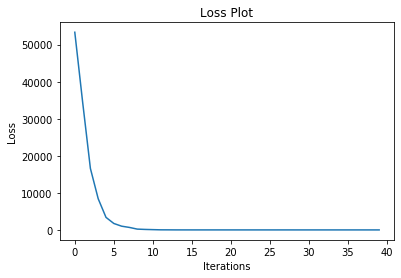

In [17]:
# Model Hyperparameters
forecastHorizon = 1
lag = 10
activation = 'relu'
numUnitsPerLayer = 20
numLayers = 2
numTargetVariables = dataTrain.shape[1]
numExoVariables = 0

# Training Hyperparameters
numIterations = 40
optimizer = tf.optimizers.Adam()

model = DeepNN(
    forecastHorizon=forecastHorizon,
    lag=lag,
    activation=activation,
    numUnitsPerLayer=numUnitsPerLayer,
    numLayers=numLayers,
    numTargetVariables=numTargetVariables,
    numExoVariables=numExoVariables
)

losses = model.train(
    trainSequences=trainSequences,
    numIterations=numIterations,
    optimizer=optimizer
)

Plot.plotLoss(losses)

In [18]:
loss, pred = model.evaluate(
    targetSeries=dataTest,
    returnPred=True
)

target = dataTest[forecastHorizon + lag:, :]

print(f'Loss on Test Set: {loss}')

Loss on Test Set: 1890.1894738632918


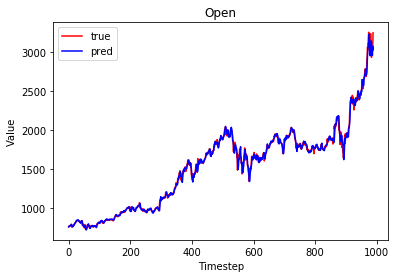

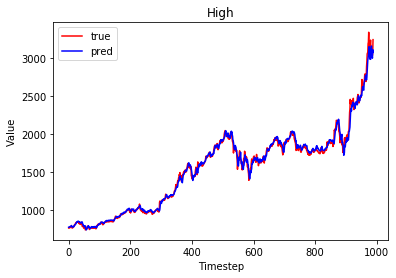

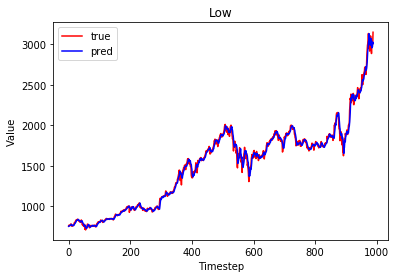

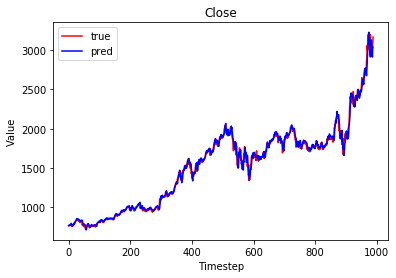

In [19]:
plotPredTrue(pred, target)

In [32]:
displayMetrics(pred, target)

Open: MAPE:  1.47 MAE:  23.86 MPE:  0.16 MSE:  1452.54 RMSE:  38.11
High: MAPE:  1.86 MAE:  30.49 MPE: -0.31 MSE:  2174.98 RMSE:  46.64
Low: MAPE:  1.79 MAE:  28.08 MPE:  0.10 MSE:  1762.89 RMSE:  41.99
Close: MAPE:  1.94 MAE:  31.51 MPE: -0.27 MSE:  2170.35 RMSE:  46.59


# GMM-HMM Likelihood Similarity based Model

In [33]:
from ts.model import GmmHmmLikelihoodSimilarity

Has model converged:  True


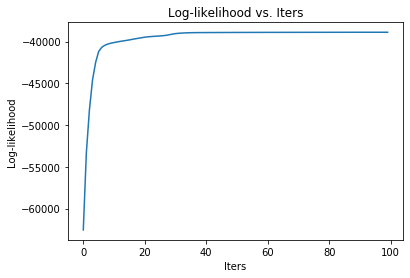

In [34]:
numStates = 6
numMixtureComp = 4
dimension = len(stock_df.columns)
numIterations = 100
threshold = 0.0
covariance_type = 'full'

model = GmmHmmLikelihoodSimilarity(
    numStates=numStates,
    numMixtureComp=numMixtureComp,
    dimension=dimension,
    numIterations=numIterations,
    threshold=threshold,
    covariance_type=covariance_type
)

logLikelihoodValues = model.train([dataTrain])

plt.plot(logLikelihoodValues, label='log-likelihood')
plt.xlabel('Iters')
plt.ylabel('Log-likelihood')
plt.title('Log-likelihood vs. Iters')
print('Has model converged: ', model.model.monitor_.converged)

In [35]:
pred = model.predict(dataTest)

In [40]:
pred = pred[:pred.shape[0] - 1]
target = dataTest[1:]
pred.shape, target.shape

((999, 4), (999, 4))

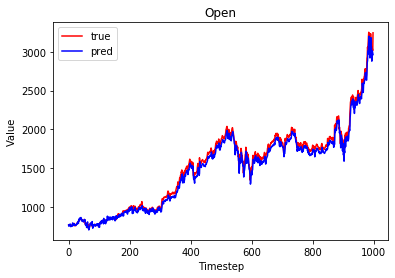

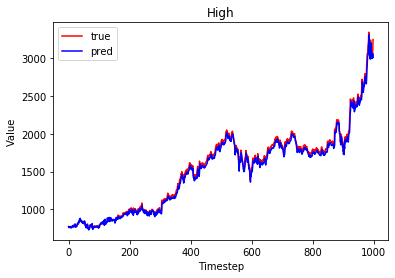

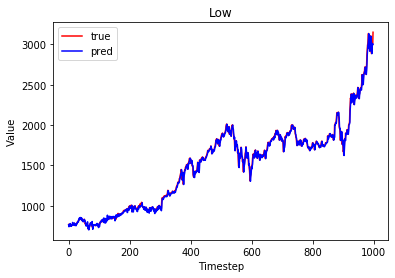

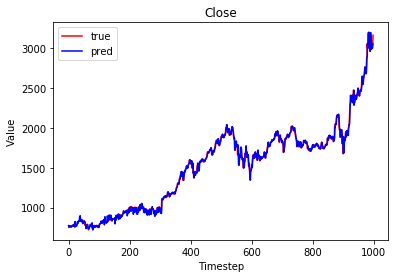

In [41]:
plotPredTrue(pred, target)

In [42]:
displayMetrics(pred, target)

Open: MAPE:  2.94 MAE:  46.65 MPE:  2.50 MSE:  3454.65 RMSE:  58.78
High: MAPE:  2.23 MAE:  35.09 MPE:  1.85 MSE:  2038.01 RMSE:  45.14
Low: MAPE:  1.51 MAE:  22.49 MPE:  0.32 MSE:  1028.11 RMSE:  32.06
Close: MAPE:  1.58 MAE:  23.41 MPE:  0.17 MSE:  1218.01 RMSE:  34.90


# LSTM model

In [43]:
from ts.model import LstmForecast

Epoch 1/10
10/10 [==============================] - 2s 172ms/step - loss: 51194.7891
Epoch 2/10
10/10 [==============================] - 2s 172ms/step - loss: 49199.7383
Epoch 3/10
10/10 [==============================] - 2s 165ms/step - loss: 46481.0977
Epoch 4/10
10/10 [==============================] - 2s 171ms/step - loss: 44710.9453
Epoch 5/10
10/10 [==============================] - 2s 165ms/step - loss: 42850.2969
Epoch 6/10
10/10 [==============================] - 2s 167ms/step - loss: 41056.3906
Epoch 7/10
10/10 [==============================] - 2s 166ms/step - loss: 41530.4570
Epoch 8/10
10/10 [==============================] - 2s 165ms/step - loss: 45519.6094
Epoch 9/10
10/10 [==============================] - 2s 165ms/step - loss: 42127.1953
Epoch 10/10
10/10 [==============================] - 2s 166ms/step - loss: 40492.2539


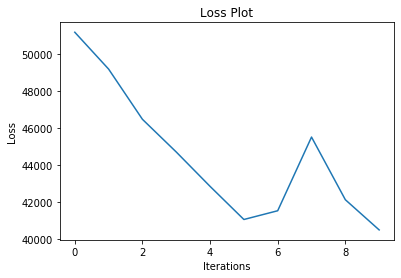

In [44]:
# Model Hyperparameters
forecastHorizon = 1
stateSize = 50
numRnnLayers = 2
numTargetVariables = dataTrain.shape[1]
numExoVariables = 0

# Training Hyperparameters
numIterations = 10
optimizer = tf.optimizers.Adam(0.05)

model = LstmForecast(
    forecastHorizon=forecastHorizon,
    stateSize=stateSize,
    numRnnLayers=numRnnLayers,
    numTargetVariables=numTargetVariables,
    numExoVariables=numExoVariables
)

model.model.build((None, None, numTargetVariables + numExoVariables))

losses = model.train(
    trainSequences=trainSequences,
    numIterations=numIterations,
    optimizer=optimizer
)

Plot.plotLoss(losses)

In [45]:
loss, pred = model.evaluate(
    targetSeries=dataTest,
    returnPred=True
)

target = dataTest[forecastHorizon:, :]

print(f'Loss on Test Set: {loss}')

Loss on Test Set: 2422033.5


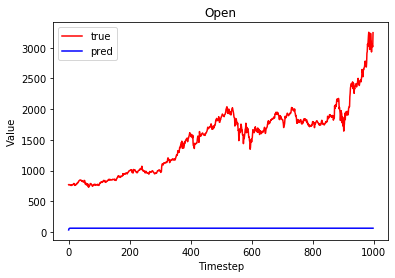

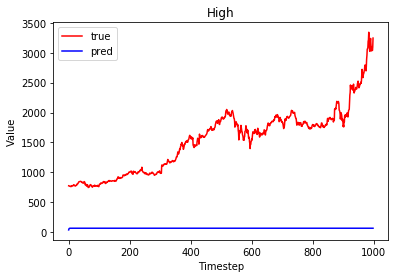

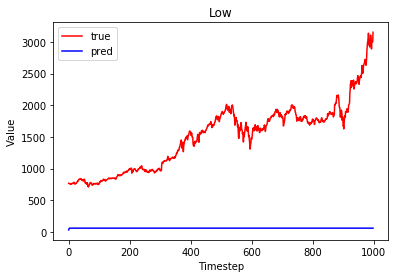

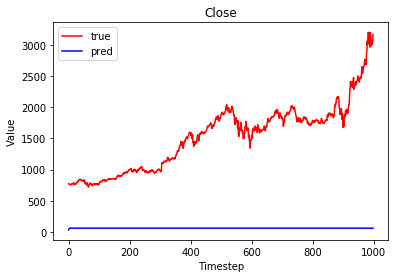

In [46]:
plotPredTrue(pred, target)

In [47]:
displayMetrics(pred, target)

Open: MAPE:  95.46 MAE:  1463.02 MPE:  95.46 MSE:  2423898.00 RMSE:  1556.89
High: MAPE:  95.41 MAE:  1477.26 MPE:  95.41 MSE:  2474879.00 RMSE:  1573.17
Low: MAPE:  95.49 MAE:  1446.64 MPE:  95.49 MSE:  2366918.50 RMSE:  1538.48
Close: MAPE:  95.41 MAE:  1462.40 MPE:  95.41 MSE:  2422437.25 RMSE:  1556.42
